## Download libraries

In [ ]:
!pip install gdown

In [32]:
# IMPORT LIBRARIES
# import gdown
import sqlite3
import pandas as pd
import plotly.express as px
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import style
style.use('ggplot')
sns.set_style("whitegrid")
sns.set_palette('colorblind')

# Suppress all warnings
# warnings.filterwarnings("ignore")


In [2]:
def check_file_exits(filepath):
    # File ID from google drive
    id = "1ViJNZGAqN4DmFIN5f_HtRAYrA0jeMuSw"
    output = 'cvr.db'

    # Check if the file exists
    if os.path.exists(filepath):
        return f"{output} exists"
    else:
        # downloads database from google drive
        gdown.download(id=id, output=output, quiet=True)
        return f"{output} Downloaded"


def db_to_pandas(filepath):
    # Downloads the data
    check_file_exits('./cvr.db')

    # Connects to DB
    conn = sqlite3.connect(filepath)
    
    # Table names present in database
    table_names = ['financials', 'observations', 'company']
    
    # Empty dictionary
    df_collection = {}
    
    # Iterate through tables in db
    for table in table_names:
        # Creates dictionary with table name as key and data as value
        df = pd.read_sql_query(f'SELECT * FROM {table}', conn)
        df_collection[table] = df
    # returns collection
    return df_collection


def merge_tables(filepath: str) -> pd.DataFrame:
    data = db_to_pandas(filepath)
    df_financials = data['financials']
    df_observations = data['observations']
    df_company = data['company']
    
    # Data Cleaning and Type conversion
    df_financials['cvr'] = df_financials['cvr'].astype(str)
    df_company['cvr_number'] = df_company['cvr_number'].astype(str)
    df_financials['publication_date'] = pd.to_datetime(df_financials['publication_date'], format='mixed')

    # Merge DataFrames
    merged_data = df_financials.merge(df_observations, on='cvr').merge(df_company, left_on='cvr', right_on='cvr_number')
    
    return merged_data



def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/ data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['types'] = types
    return(np.transpose(tt))


def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique) 
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [3]:
# merges all three tables into one
df = merge_tables('./cvr.db')

In [4]:
# Analysis 1: Companies with More Than 5 Years of Profitability
# Assuming profit_loss > 0 indicates profitability
# Shows the number of times each company has made a profit

profit_years = df.groupby(['cvr','year'])['profit_loss'].apply(lambda x: (x > 0).sum()).reset_index()

profit_years = profit_years.groupby('cvr')['profit_loss'].apply(lambda x: (x > 0).sum()).sort_values(ascending=False)

five_yr_or_more_profit_companies = profit_years[profit_years >= 5].index.tolist()

In [5]:
# Filter merged_data for profitable companies
filtered_data = df[df['cvr'].isin(five_yr_or_more_profit_companies)]

# Analysis 2: Sudden Decline in Net Income
# We define 'sudden decline' as negative profit_loss in the last 2-8 years after a period of profitability
# This requires sorting by date and checking the recent two years
filtered_data = filtered_data.sort_values(by='publication_date')

decline_companies = []

# Iterate through each group
for cvr, group in filtered_data.groupby('cvr'):
    if len(group) >= 10:
        last_two_years_profit = group.iloc[-10:-2]['profit_loss'].sum()
        year_before_last_profit = group.iloc[-10:-9]['profit_loss'].sum()
        if last_two_years_profit < 0 and year_before_last_profit > 0:
            decline_companies.append(cvr)

# Now decline_companies contains the list of companies that meet the condition

In [6]:
# Analysis 3: Low Debt Levels
# Using debt to equity ratio as an example (debt_obligations / equity)
# A ratio < 0.4 could be considered as low debt level
filtered_data['debt_to_equity'] = filtered_data['debt_obligations'] / filtered_data['equity']

low_debt_companies = filtered_data[filtered_data['debt_to_equity'] < 0.4]['cvr'].unique()

In [8]:
# Final Filtered Companies
final_companies = set(five_yr_or_more_profit_companies) & set(decline_companies) & set(low_debt_companies)

In [ ]:
# Visualization: Profit/Loss Trend for these companies
# Takes cvr from final companies
for cvr in final_companies:
    # filters for data for that particular cvr and make a plot of it
    company_data = filtered_data[filtered_data['cvr'] == cvr]
    sns.lineplot(x='publication_date', y='profit_loss', data=company_data)
    plt.title(f"Profit/Loss Trend for Company CVR:{cvr}")
    plt.xlabel('Year')
    plt.ylabel('Profit/Loss')
    plt.show()
    break

No Enteries for data
No Enteries for data


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


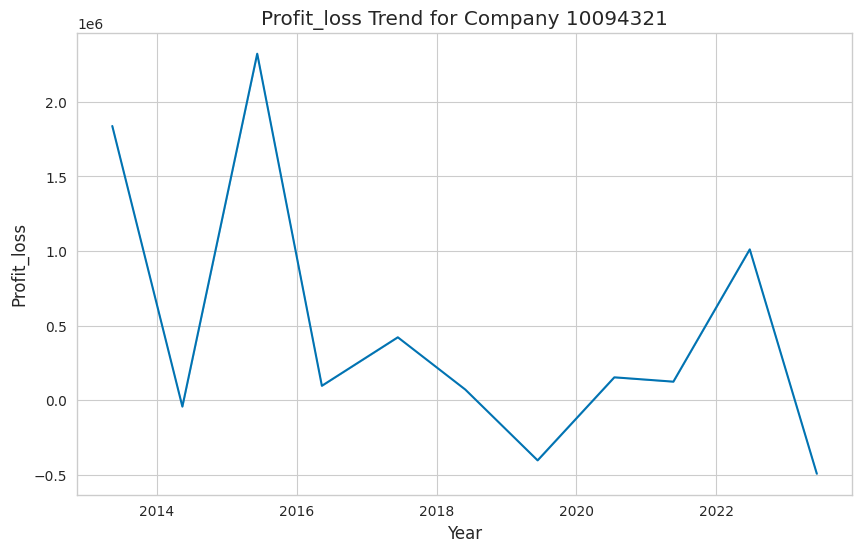

In [51]:
# Trend Analysis
metrics_to_analyze = ['revenue', 'external_expenses', 'profit_loss'] # add revenue
for metric in metrics_to_analyze:
    for cvr in final_companies:
        company_data = filtered_data[filtered_data['cvr'] == cvr]
        if company_data[f'{metric}'].sum() <= 0:
            print('No Enteries for data')
        else:
            plt.figure(figsize=(10, 6))
            sns.lineplot(x='publication_date', y=metric, data=company_data)
            plt.title(f"{metric.capitalize()} Trend for Company {cvr}")
            plt.xlabel('Year')
            plt.ylabel(metric.capitalize())
            plt.show()
        break


In [58]:
filtered_data.select_dtypes('object').columns

Index(['pdf_url', 'reporting_period_start_date', 'sort_key_x',
       'date_of_approval_of_annual_report', 'reporting_period_end_date',
       'pk_x', 'cvr', 'auditor_reprimand', 'title', 'status_x', 'description',
       'industry_text', 'long_description', 'status_y', 'name', 'cvr_number',
       'short_description', 'industry_sector', 'unit_type', 'website_url',
       'last_updated', 'last_loaded', 'responsible_data_providers',
       'sort_key_y', 'effective_actor', 'alt_names', 'establishment_date',
       'status_valid_from', 'pk_y', 'effective_date', 'purpose',
       'company_binding', 'capital_partly', 'capital_currency',
       'first_financial_year_start', 'first_financial_year_end',
       'financial_year_end', 'financial_year_start', 'current_revision',
       'email', 'phone_number', 'secondary_industry', 'status_valid_to'],
      dtype='object')

In [62]:
filtered_data[['industry_sector', 'purpose']]

,industry_sector,purpose
2832976,G,Selskabets formål er at drive handel med belys...
3501944,P,Selskabets formål er at drive kursus- og konsu...
3501945,P,Selskabets formål er at drive kursus- og konsu...
3501946,P,Selskabets formål er at drive kursus- og konsu...
3501947,P,Selskabets formål er at drive kursus- og konsu...
...,...,...
2898094,C,Virksomhedens formål er at drive virksomhed me...
2898099,C,Virksomhedens formål er at drive virksomhed me...
2898097,C,Virksomhedens formål er at drive virksomhed me...
2898095,C,Virksomhedens formål er at drive virksomhed me...


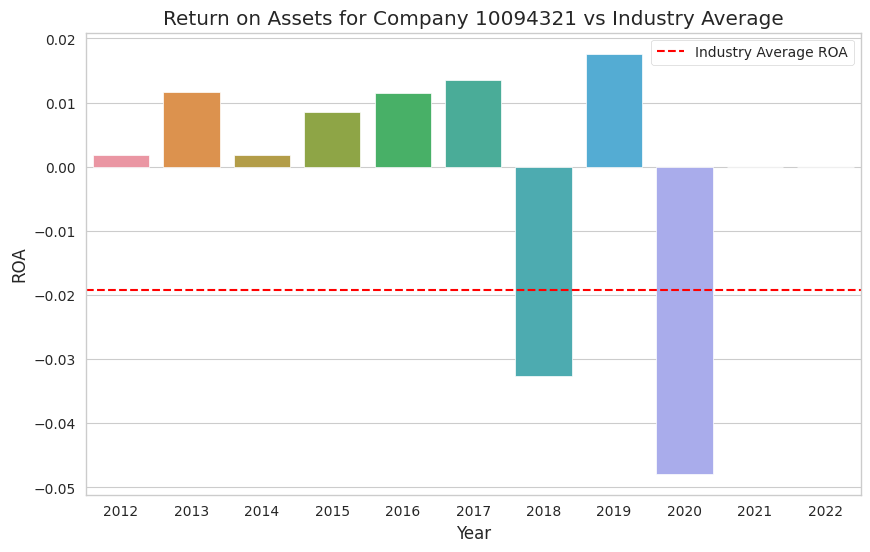

In [76]:
# Comparison Analysis
# This requires industry averages which might be in a separate dataset or need to be calculated
# Example: Compare return on assets (ROA)

industry_roa = filtered_data.groupby('industry_code')['return_on_assets'].mean()
for cvr in final_companies:
    company_data = filtered_data[filtered_data['cvr'] == cvr]
    industry_code = company_data['industry_code'].iloc[0]
    avg_roa = industry_roa[industry_code]
    plt.figure(figsize=(10, 6))
    sns.barplot(x='year', y='return_on_assets', data=company_data)
    plt.axhline(y=avg_roa, color='r', linestyle='--', label='Industry Average ROA')
    plt.title(f"Return on Assets for Company {cvr} vs Industry Average")
    plt.xlabel('Year')
    plt.ylabel('ROA')
    plt.legend()
    plt.show()
    break


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


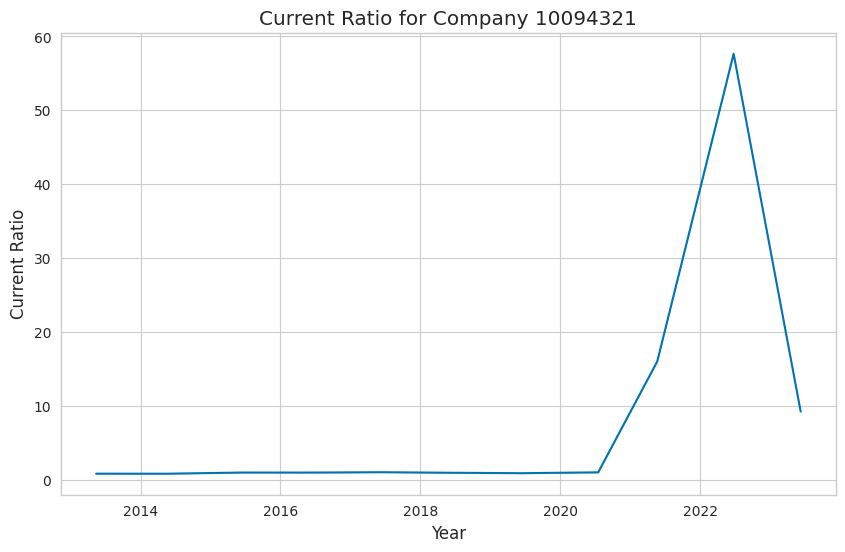

In [77]:

# Financial Health Indicators
# Example: Current Ratio Analysis
for cvr in final_companies:
    company_data = filtered_data[filtered_data['cvr'] == cvr]
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='publication_date', y='current_ratio', data=company_data)
    plt.title(f"Current Ratio for Company {cvr}")
    plt.xlabel('Year')
    plt.ylabel('Current Ratio')
    plt.show()
    break



In [ ]:
# Assuming observations DataFrame is already loaded
# ...

# Analyzing frequency of different titles (assuming 'title' might indicate the type of observation)
observation_titles = observations['title'].value_counts()
print("Most Common Observation Titles:")
print(observation_titles.head(10))  # Display the top 10 observation titles


# Analyzing Industry Sectors
industry_counts = company['industry_sector'].value_counts()
print("Most Common Industry Sectors:")
print(industry_counts.head(10))  # Display the top 10 industries

# Analyzing Company Size by Employee Count
company['employee_count'].describe()

# Visualizing Distribution of Employee Counts
plt.figure(figsize=(10, 6))
sns.histplot(company['employee_count'].dropna(), bins=30, kde=True)
plt.title("Distribution of Employee Counts in Companies")
plt.xlabel("Employee Count")
plt.ylabel("Frequency")
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


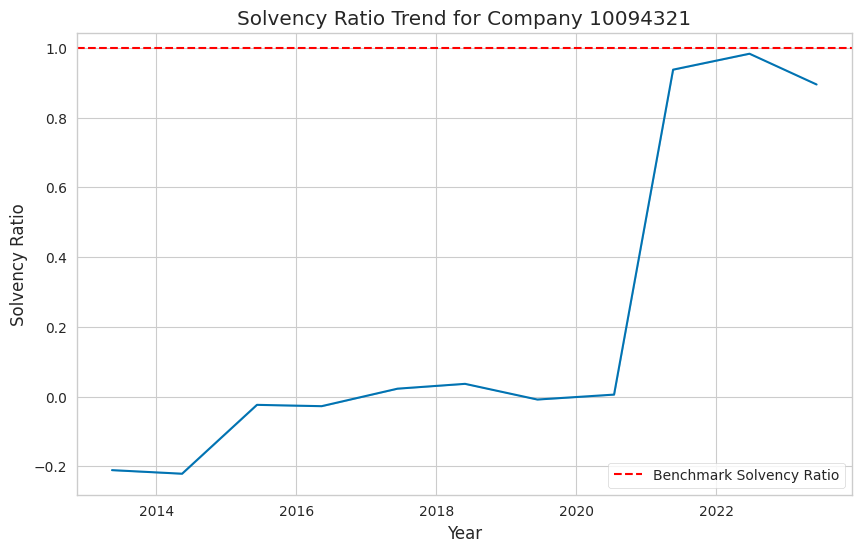

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


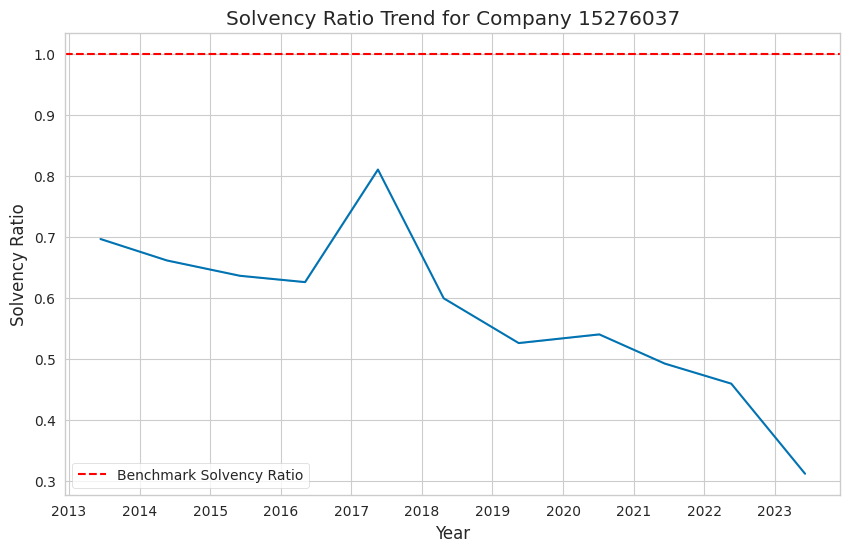

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


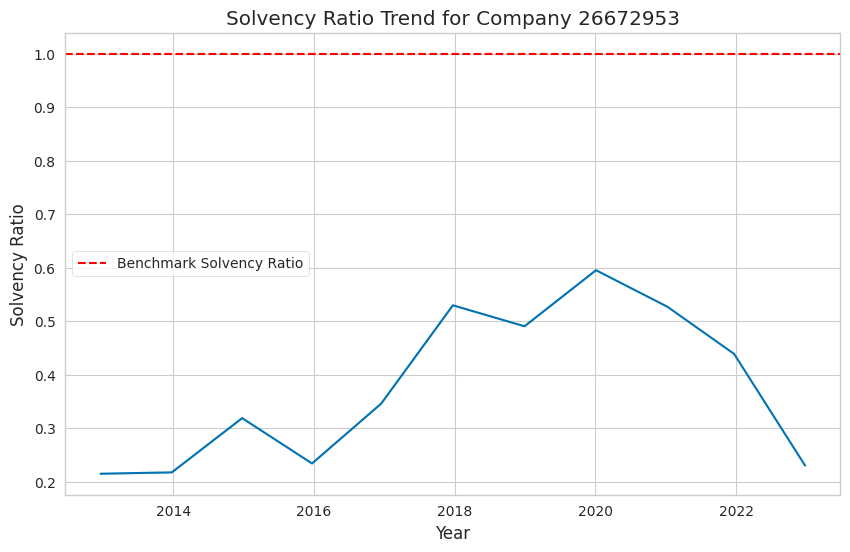

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


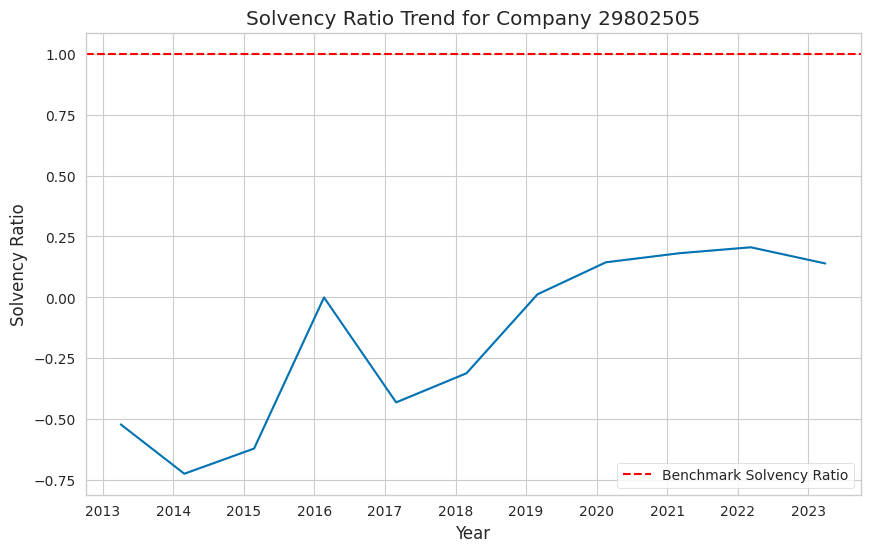

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


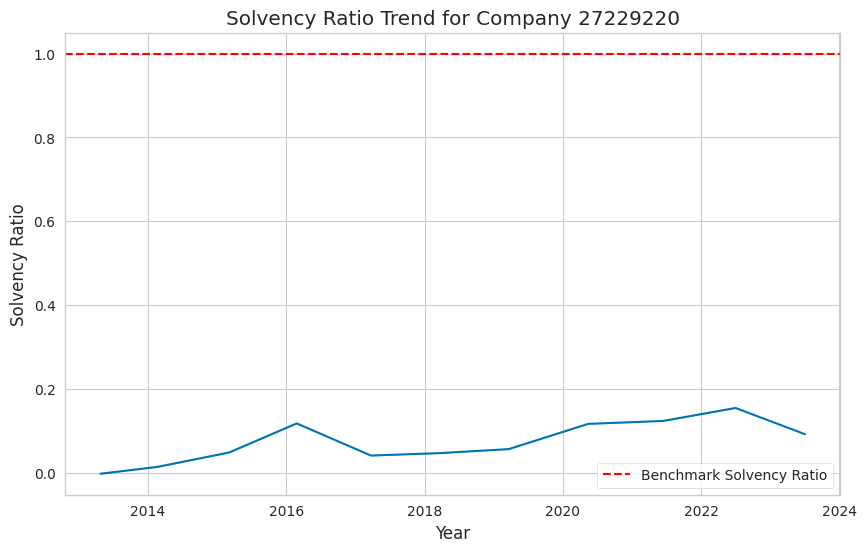

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


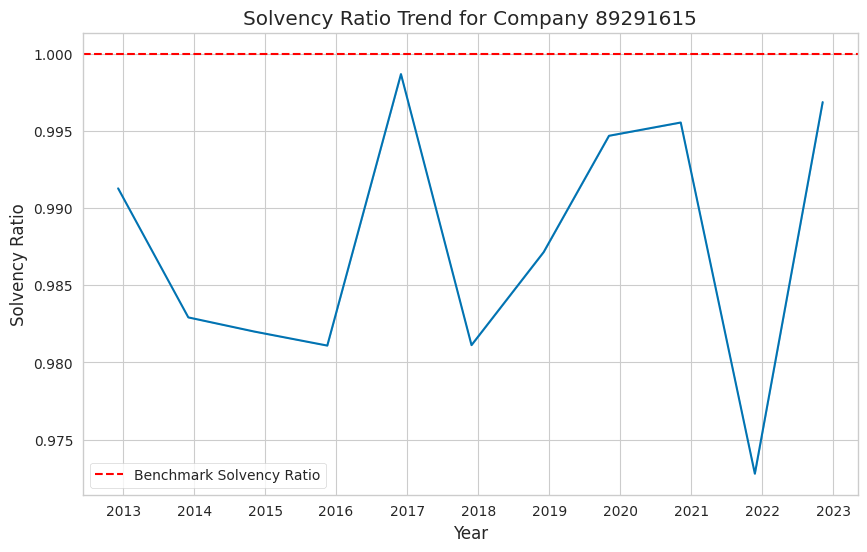

KeyboardInterrupt: 

In [79]:
# Insight: Financial Health - Solvency Ratio Analysis
# Example: Analyze the solvency ratio trend
for cvr in final_companies:
    company_data = filtered_data[filtered_data['cvr'] == cvr]
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='publication_date', y='solvency_ratio', data=company_data)
    plt.title(f"Solvency Ratio Trend for Company {cvr}")
    plt.xlabel('Year')
    plt.ylabel('Solvency Ratio')
    plt.axhline(y=1, color='r', linestyle='--', label='Benchmark Solvency Ratio')
    plt.legend()
    plt.show()
    break

No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data
No Enteries for data


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

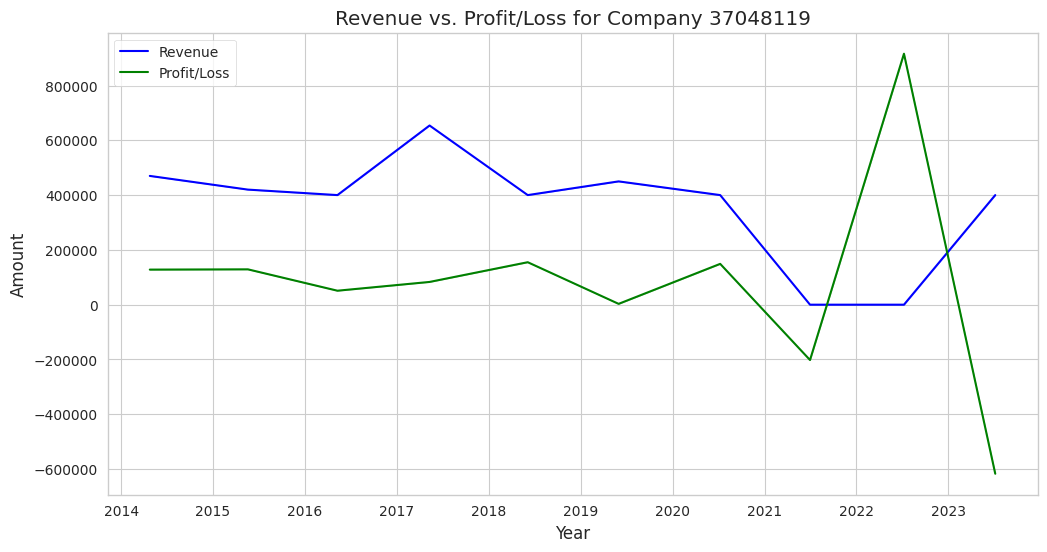

In [83]:
# Insight: Correlation Between Revenue and Profit/Loss
for cvr in final_companies:
    company_data = filtered_data[filtered_data['cvr'] == cvr]
    if company_data['revenue'].sum() <= 0:
        print('No Enteries for data')
        continue
    else:    
        plt.figure(figsize=(12, 6))

        # Plot Revenue
        sns.lineplot(x='publication_date', y='revenue', data=company_data, label='Revenue', color='blue')

        # Plot Profit/Loss
        sns.lineplot(x='publication_date', y='profit_loss', data=company_data, label='Profit/Loss', color='green')

        plt.title(f"Revenue vs. Profit/Loss for Company {cvr}")
        plt.xlabel('Year')
        plt.ylabel('Amount')
        plt.legend()
        plt.show()
        break

In [ ]:
# Benchmarking Analysis for Business Owners
industry_code = [YOUR_INDUSTRY_CODE]  # Replace with the industry code of interest
region = [YOUR_REGION]  # Replace with the region of interest

industry_data = filtered_data[filtered_data['industry_code'] == industry_code]
region_data = industry_data[industry_data['region'] == region]  # Assuming 'region' is a column

metrics = ['revenue', 'profit_loss', 'employee_count']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='year', y=metric, data=region_data)
    plt.title(f"{metric.capitalize()} Benchmark in {region}")
    plt.xlabel('Year')
    plt.ylabel(metric.capitalize())
    plt.show()

                 count       mean        std   min   25%   50%    75%    max
industry_code                                                               
11100           9189.0   5.300794   8.140678   1.0   1.0   2.0    6.0   54.0
11300           2741.0  36.059467  83.601451   1.0   2.0   7.0   18.0  346.0
11900           2291.0  14.089481  29.163915   1.0   1.0   2.0   10.0  105.0
12400            652.0   5.036810   4.325667   1.0   2.0   3.0   11.0   12.0
12500            297.0  86.333333  58.364014  36.0  36.0  55.0  168.0  168.0
...                ...        ...        ...   ...   ...   ...    ...    ...
960210         18149.0   4.843738   7.669669   1.0   1.0   3.0    6.0   80.0
960220          6204.0   5.484848  11.969839   1.0   1.0   2.0    5.0   81.0
960300          5194.0   5.627455   3.727067   1.0   3.0   5.0    8.0   16.0
960400          5545.0   9.655365  14.283440   1.0   1.0   3.0   11.0   80.0
960900          4226.0   4.153100   5.955177   1.0   1.0   2.0    6.0   29.0

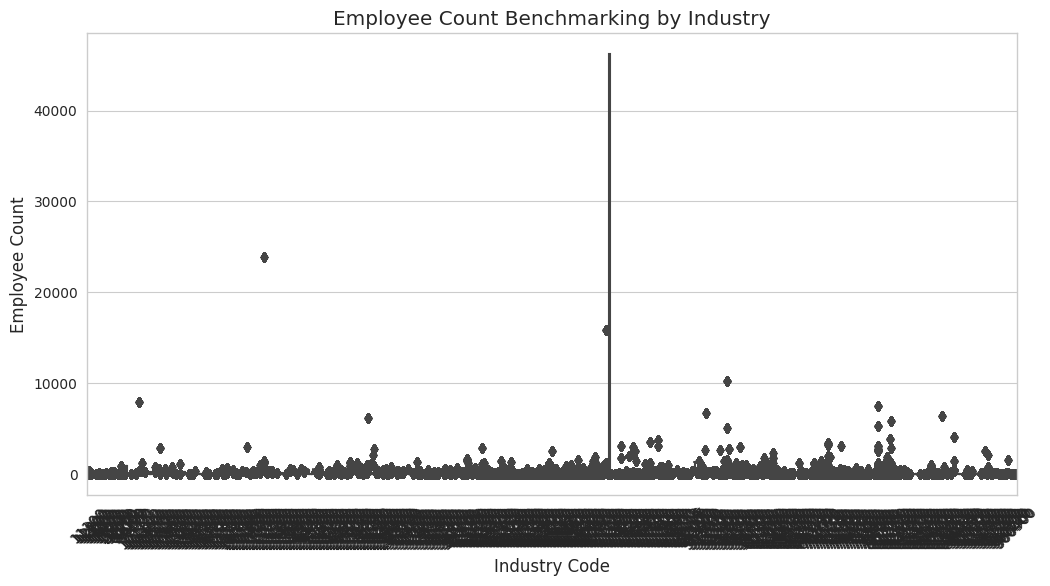

In [84]:
# Filter data for relevant columns
benchmark_data = filtered_data[['cvr', 'industry_code', 'employee_count']]

# Drop rows where employee count is missing
benchmark_data = benchmark_data.dropna(subset=['employee_count'])

# Convert employee count to an appropriate type (if not already)
benchmark_data['employee_count'] = benchmark_data['employee_count'].astype(int)

# Group by industry and calculate summary statistics for employee count
industry_employee_stats = benchmark_data.groupby('industry_code')['employee_count'].describe()

# Display the statistics
print(industry_employee_stats)

### adapt this to my use case for comparison between two companies
###
# Visualization: Distribution of employee count by industry
plt.figure(figsize=(12, 6))
sns.boxplot(x='industry_code', y='employee_count', data=benchmark_data)
plt.xticks(rotation=45)
plt.title("Employee Count Benchmarking by Industry")
plt.xlabel("Industry Code")
plt.ylabel("Employee Count")
plt.show()